# Using cluster for semi-suvervised learning

In [9]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_digits, y_digits = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits)

In [14]:
log_reg = LogisticRegression(random_state=42)
ln_labeled = 50
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled]) # These 50 are the labeled data

/home/arman/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [15]:
log_reg.score(X_test, y_test)

0.8111111111111111

In [17]:
from sklearn.cluster import KMeans

k = 50 # Though there is 10 digits but there are also several ways to write each digits
kmeans = KMeans(n_clusters=k)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis = 0) # Finds the 50 min point or the cluster centroid.
X_representative_digit = X_train[representative_digit_idx]

/home/arman/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


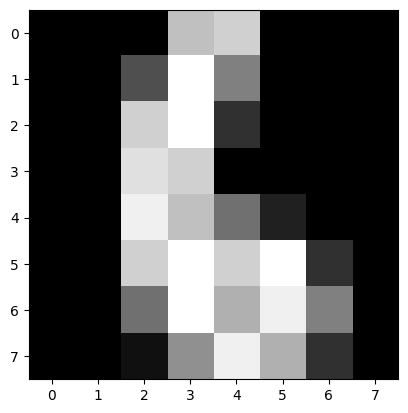

In [24]:
import matplotlib.pyplot as plt
import matplotlib as mlp

some_digit_image = X_representative_digit[2].reshape(8,8)
plt.imshow(some_digit_image, cmap = mlp.cm.gray, interpolation = 'nearest')
plt.show()

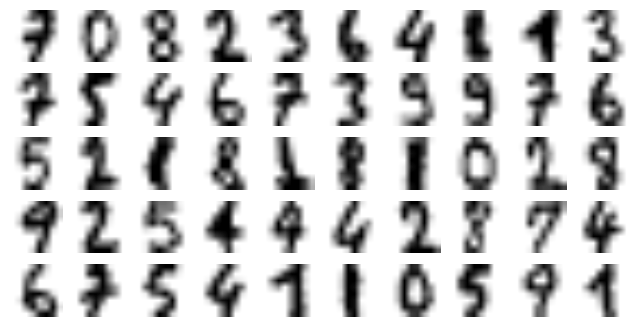

In [29]:


kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]



plt.figure(figsize=(8, 4))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

plt.show()


In [30]:
# ^ these are the 50 cluster groups min digits

In [31]:
y_train[representative_digit_idx]

array([7, 0, 8, 2, 3, 6, 4, 1, 1, 3, 7, 5, 4, 6, 7, 3, 9, 9, 7, 6, 5, 2,
       1, 8, 1, 8, 1, 0, 2, 8, 9, 2, 5, 4, 4, 4, 2, 8, 7, 4, 6, 7, 5, 4,
       1, 1, 0, 5, 9, 1])

In [32]:
import numpy as np
y_representative_digits = np.array([7, 0, 8, 2, 3, 6, 4, 1, 1, 3, 7, 5, 4, 6, 7, 3, 9, 9, 7, 6, 5, 2,
       1, 8, 1, 8, 1, 0, 2, 8, 9, 2, 5, 4, 4, 4, 2, 8, 7, 4, 6, 7, 5, 4,
       1, 1, 0, 5, 9, 1])

In [35]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test) # Improves scores cause using the representative digit

0.8977777777777778

# Labeled propagation

In [37]:
# When we labeled each clusters intances as the representaive (meaning each instance has a label)that is called labeled propagarion

y_train_propagated = np.empty(len(X_train), dtype = np.int32)

for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i] 

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test) # Score will increase

/home/arman/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9111111111111111

# Not propagating the boundary digits

In [45]:
# The following will propage those 20% instances that are close to the cluster

percentile_closest = 20
X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_] # Extracts distances of each training example to
                                                                        # its assigned cluster center from the KMeans results.
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]
log_reg = LogisticRegression()
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

/home/arman/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9311111111111111

In [47]:
# The reason for the performance increase is that the points closest to the cluster are 99% accurate

np.mean(y_train_partially_propagated == y_train[partially_propagated]) # Partially_propaget holds the index that will be labeled

0.9965397923875432

# DBSCAN

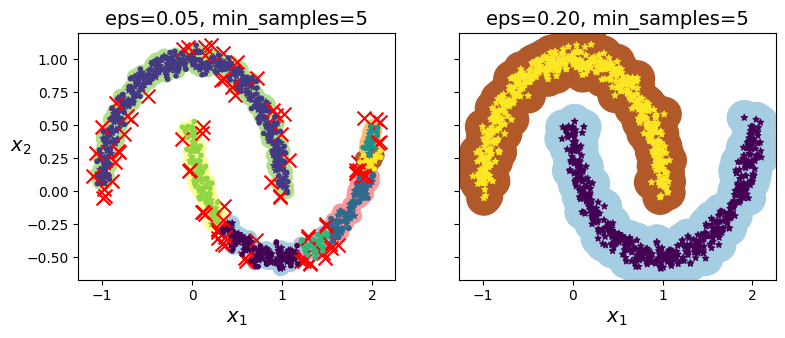

In [59]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
import os

dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)


def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.show()

# GMM(Gaussiam Mixture Model)

In [61]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components = 3, n_init = 10)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10)

In [64]:
gm.n_iter_ # Shows how interation it took
gm.converged_ # shows if it converged or not
gm.weights_
gm.means_
gm.covariances_   # These are values assigined by GMM

array([[[ 0.05012086,  0.05880894],
        [ 0.05880894,  0.08478928]],

       [[ 0.17488289, -0.10514628],
        [-0.10514628,  0.2918721 ]],

       [[ 0.05176171,  0.05999695],
        [ 0.05999695,  0.08431737]]])

In [66]:
X_new, y_new = gm.sample(6) # generate 6 new samples from GMM similar with the data GMM was trained on

In [67]:
X_new

array([[-0.67513771,  0.62611905],
       [-0.58969205,  0.82320342],
       [ 0.63571059,  0.77147745],
       [ 0.31954127,  0.25406468],
       [ 0.18991367,  0.05394231],
       [ 1.98746765,  0.03399778]])

In [71]:
a = gm.score_samples(X) # Calculated the density of the data points
len(a) # 1000 density value for 1000 dadta points

1000

In [72]:
import tensorflow

ModuleNotFoundError: No module named 'tensorflow'